# Определение стоимости автомобилей

Исследование для сервиса по продаже автомобилей «Не бит, не крашен». Сервис разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Нужно построить модель, которая умеет определять эту стоимость. В распоряжении исследователя данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

In [1]:
# загружаю все нужные для проекта библиотеки

!pip install --upgrade scikit-learn
!pip install lightgbm 
!pip install scipy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import phik
import lightgbm as lgb

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
from numpy.random import RandomState
from lightgbm import LGBMRegressor
from time import time



In [2]:
def load_data(file_name): # загрузка данных
    data = pd.read_csv(file_name)
    print(data.head())
    data.info()
    return data

def plot_data(x, y, data, title, ax):
    sns.boxplot(x=x, y=y, data=data, ax=ax) # ящик с усами
    ax.set_title(title)

def scatterplot_data(x, y, data, title, ax):
    sns.histplot(x=x, y=y, data=data, ax=ax) # диаграмма рассеяния
    ax.set_title(title)

def rmse (y_true, y_pred): # расчёт метрики rmse
    return sqrt(mean_squared_error(y_true, y_pred))

def data_for_model(data, drop_col, num_columns, ohe_columns): # подготовка данных для моделей
    X = data.drop(drop_col, axis=1)
    y = data[drop_col[0]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)
    
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
    X_test_ohe = encoder.transform(X_test[ohe_columns])
    encoder_col_names = encoder.get_feature_names_out()
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    standard = StandardScaler()
    X_train_scaled = standard.fit_transform(X_train[num_columns])
    X_test_scaled = standard.transform(X_test[num_columns])
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    return X_train, X_test, y_train, y_test


def model_fit_predict(model, params, X_train, y_train): # обучение модели и предсказания
    
    randomized_search = RandomizedSearchCV(model, params, cv=5, scoring=rmse_scorer, random_state=RANDOM_STATE, n_jobs=-1, error_score='raise')
    randomized_search.fit(X_train, y_train)
    # сохраняю результат в переменную predictions
    rmse_cv = randomized_search.best_score_
    model = randomized_search.best_estimator_
    return rmse_cv, model

## Загрузка и изучение данных

In [3]:
try:
    auto_data = load_data('/Users/ira-bobrineva/Downloads/autos.csv')
except:
    auto_data = load_data('/datasets/autos.csv') 

           DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00

In [4]:
auto_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Пока можно сделать такие выводы по данным: в ряде столбцов есть пропущенные данные (VehicleType, Gearbox, Model, FuelType, Repaired) и нулевые значения (Power, RegistrationMonth, Price). Чтобы понять, удалять ли пропуски и нулевые значения или попробовать их заполнить чем-нибудь, нужно посчитать долю этих пропусков и нулей. Ещё все даты записаны с типом данных object. Эти значения не понадобятся для настройки модели, но могут быть использованы при предобработке данных. Возможно, нужно будет привести какие-то даты к datetime. Приведу ещё названия признаков к snake_case.

## Предобработка данных

### Обработка названий столбцов

In [5]:
auto_data.columns = auto_data.columns.str.lower()
auto_data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
auto_data = auto_data.rename(columns={'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year', 'registrationmonth': 'registration_month', 'fueltype': 'fuel_type'}) # обработала только значимые для модели столбцы
auto_data.head()


,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Удаление полных дубликатов

In [7]:
auto_data.duplicated().sum()

4

In [8]:
auto_data = auto_data.drop_duplicates().reset_index(drop=True) # поправлю ещё порядок индексов в датафрейме после удаления дубликатов
auto_data.duplicated().sum()

0

### Обработка неявных дубликатов

In [9]:
auto_data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [10]:
auto_data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [11]:
auto_data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [12]:
model_amount = auto_data.pivot_table(index='model', values='datecrawled', aggfunc='count')
model_amount.columns = ['Частота встречаемости']
model_amount.sort_values(by='Частота встречаемости', ascending=False)

,Частота встречаемости
model,
golf,29232
other,24420
3er,19761
polo,13066
corsa,12570
...,...
serie_2,8
serie_3,4
rangerover,4


In [13]:
bmw_data = auto_data.query('model == "6er" or model == "6_reihe"')
bmw_data

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
291,2016-04-01 00:51:10,2000,sedan,2004,manual,122,6_reihe,5000,7,gasoline,mazda,no,2016-03-31 00:00:00,0,54558,2016-04-05 00:44:27
362,2016-03-30 13:53:41,16500,coupe,1983,manual,218,6er,150000,10,petrol,bmw,no,2016-03-30 00:00:00,0,42719,2016-04-01 08:18:11
421,2016-03-08 18:51:16,350,wagon,1998,manual,0,6_reihe,150000,0,petrol,mazda,yes,2016-03-08 00:00:00,0,54655,2016-04-07 14:56:13
540,2016-03-05 15:52:50,600,sedan,1994,manual,105,6_reihe,150000,4,petrol,mazda,no,2016-03-05 00:00:00,0,30627,2016-04-03 17:45:54
572,2016-03-10 20:47:58,3000,sedan,2002,manual,116,6_reihe,90000,6,petrol,mazda,no,2016-03-10 00:00:00,0,22955,2016-04-06 08:15:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353112,2016-03-22 09:45:51,9900,convertible,2004,manual,333,6er,150000,10,petrol,bmw,no,2016-03-22 00:00:00,0,99867,2016-04-05 20:44:43
353561,2016-03-26 21:59:58,3200,wagon,2006,manual,143,6_reihe,150000,3,gasoline,mazda,no,2016-03-26 00:00:00,0,16816,2016-03-26 23:45:05
353839,2016-03-26 11:53:43,2250,sedan,2001,manual,116,6_reihe,70000,1,petrol,mazda,no,2016-03-26 00:00:00,0,26607,2016-03-26 12:43:49
353951,2016-03-29 15:42:11,12800,coupe,2005,auto,333,6er,150000,3,petrol,bmw,NaN,2016-03-29 00:00:00,0,37081,2016-04-06 01:15:44


На первый взгляд кажется, что модели промаркированные как 6er, 3er, 5er и тд - то же самое, что и 6_reihe, 3_reihe и тд (в интернете говорят, что это одна и та же модель BMW - 3-Series, reihe - это series по-немецки). Но при более детальном анализе видно, что это всё же разные бренды - reihe относится к mazda, а er - к bmw. Но в моделях всё же есть неявный дубликат: range_rover и rangerover. Объединим дубликаты в одну модель - rangerover.

In [14]:
auto_data['model'] = auto_data['model'].replace('range_rover', 'rangerover')
range_rovers = auto_data.query('model == "range_rover" or model == "rangerover"')
range_rovers.head()

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
5615,2016-03-20 11:43:28,14900,suv,1993,auto,182,rangerover,150000,11,petrol,land_rover,no,2016-03-20 00:00:00,0,10781,2016-04-06 08:46:41
22356,2016-03-22 13:49:59,2800,suv,1996,auto,224,rangerover,150000,1,NaN,land_rover,no,2016-03-22 00:00:00,0,59075,2016-04-06 02:45:52
26526,2016-03-05 17:56:02,5600,suv,1982,manual,125,rangerover,5000,5,petrol,land_rover,NaN,2016-03-02 00:00:00,0,52068,2016-04-06 04:16:41
27949,2016-03-18 01:57:30,1050,small,1998,manual,103,rangerover,150000,10,petrol,rover,NaN,2016-03-18 00:00:00,0,49084,2016-04-05 21:18:19
32216,2016-04-05 00:39:33,14950,suv,1994,auto,182,rangerover,150000,7,petrol,land_rover,no,2016-04-04 00:00:00,0,34123,2016-04-07 08:15:37


In [15]:
auto_data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [16]:
fuel_amount = auto_data.pivot_table(index='fuel_type', values='datecrawled', aggfunc='count')
fuel_amount.columns = ['Частота встречаемости']
fuel_amount.sort_values(by='Частота встречаемости', ascending=False)

,Частота встречаемости
fuel_type,
petrol,216349
gasoline,98719
lpg,5310
cng,565
hybrid,233
other,204
electric,90


Неявные дубликаты такие: gasoline и petrol (это один и тот же вид топлива - бензин, просто в UK пишут Petrol, а в USA - gasoline). Преподаватель уточнил, что автор работал с этими значениями не как с дубликатами плюс значений gasoline слишком много, чтобы просто объединить их с petrol, поэтому представим, что gasoline - это дизель.

In [17]:
auto_data['fuel_type'] = auto_data['fuel_type'].replace('gasoline', 'diesel_fuel')
auto_data['fuel_type'].head()

0         petrol
1    diesel_fuel
2    diesel_fuel
3         petrol
4    diesel_fuel
Name: fuel_type, dtype: object

In [18]:
auto_data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [19]:
auto_data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

### Обработка пропущенных значений

В столбцах price, power и registration_month есть нулевые значения. Заменю их на пустые, чтобы оценить долю пропущенных значений.

In [20]:
data_with_nulls = ['price', 'power', 'registration_month']
auto_data[data_with_nulls] = auto_data[data_with_nulls].replace(0, np.nan)

In [21]:
auto_data.isna().mean() * 100 # подсчитываю долю пропусков по данным

datecrawled            0.000000
price                  3.039804
vehicle_type          10.579487
registration_year      0.000000
gearbox                5.596772
power                 11.351290
model                  5.560651
kilometer              0.000000
registration_month    10.540544
fuel_type              9.282802
brand                  0.000000
repaired              20.079297
datecreated            0.000000
numberofpictures       0.000000
postalcode             0.000000
lastseen               0.000000
dtype: float64

In [22]:
auto_data['power'] = auto_data['power'].replace(np.nan, 0)

Пропущенных значений в колонках price, gearbox и model меньше 10%, поэтому строки с нулевыми значениями в price можно удалить, а в gearbox и model можно заполнить пропуски значением 'unknown', чтобы не потерять сценарии. Пропуски в значениях repaired логично заменить на 'no', потому что скорее всего люди не заполняли этот блок, чтобы не снижать стоимость автомобиля из-за отсутствия ремонта. Думаю, месяц регистрации тоже можно удалить, потому что на цену автомобиля обычно влияет год, а не месяц. Пропущенные значения в остальных колонках заменю на unknown.

In [23]:
# удаляю строки без указания цены
auto_data = auto_data.dropna(subset=['price']).reset_index(drop=True)

In [24]:
# удаляю лишние столбцы
drop_cols = ['datecrawled', 'registration_month', 'numberofpictures', 'postalcode', 'lastseen']
auto_data = auto_data.drop(drop_cols, axis=1)

In [25]:
auto_data['repaired'] = auto_data['repaired'].replace(np.nan, 'no')


auto_data[['vehicle_type', 'fuel_type', 'gearbox', 'model']] = auto_data[['vehicle_type', 'fuel_type', 'gearbox', 'model']].replace(np.nan, 'unknown')
auto_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,datecreated
0,480.0,unknown,1993,manual,0.0,golf,150000,petrol,volkswagen,no,2016-03-24 00:00:00
1,18300.0,coupe,2011,manual,190.0,unknown,125000,diesel_fuel,audi,yes,2016-03-24 00:00:00
2,9800.0,suv,2004,auto,163.0,grand,125000,diesel_fuel,jeep,no,2016-03-14 00:00:00
3,1500.0,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600.0,small,2008,manual,69.0,fabia,90000,diesel_fuel,skoda,no,2016-03-31 00:00:00


In [26]:
auto_data.isna().mean() * 100

price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
repaired             0.0
datecreated          0.0
dtype: float64

##  Исследовательский анализ данных

### Распределение категориальных признаков

Посмотрю на распределение количественных значений.

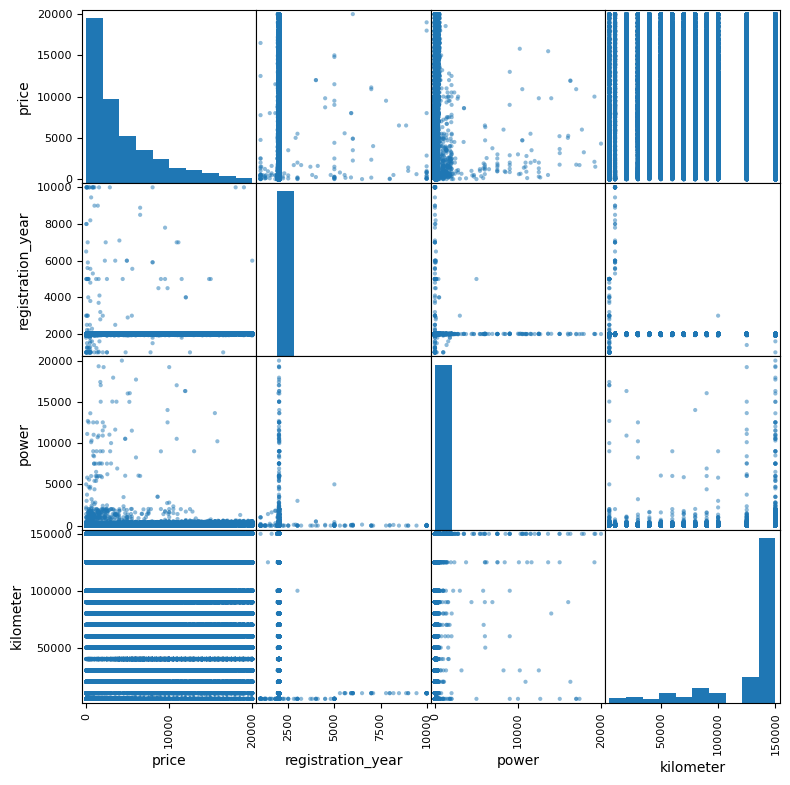

In [27]:
pd.plotting.scatter_matrix(auto_data, figsize=(9, 9))
plt.show()

В распределениях мощности и года регистрации есть много выбросов и нулевых значений. Встречаются года выше 3000 и мощность выше 500 л.с. (выше 500 л.с. - это очень мощные машины. Судя по датасету, здесь всё-таки большинство авто - лёгковушки, максимум автобусы). Такие значения нужно обработать, чтобы модель лучше предсказывала. Просто удалю строки с таким значением. 

In [28]:
# чтобы поработать с registration_year, буду использовать год в колонке datecreated
# год регистрации не может быть больше года создания анкеты
# поправлю тип данных в datecreated с object на datetime
auto_data['datecreated'] = pd.to_datetime(auto_data['datecreated'])
auto_data['datecreated'] = auto_data['datecreated'].dt.year
date_to_drop = auto_data.loc[(auto_data['registration_year'] > auto_data['datecreated']) | (auto_data['registration_year'] < 1910)].index
auto_data = auto_data.drop(date_to_drop) # удалю значения, которые не соответствуют условию, потому что их немного

auto_data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,datecreated
0,480.0,unknown,1993,manual,0.0,golf,150000,petrol,volkswagen,no,2016
1,18300.0,coupe,2011,manual,190.0,unknown,125000,diesel_fuel,audi,yes,2016
2,9800.0,suv,2004,auto,163.0,grand,125000,diesel_fuel,jeep,no,2016
3,1500.0,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2016
4,3600.0,small,2008,manual,69.0,fabia,90000,diesel_fuel,skoda,no,2016
...,...,...,...,...,...,...,...,...,...,...,...
343588,1150.0,bus,2000,manual,0.0,zafira,150000,petrol,opel,no,2016
343589,2200.0,unknown,2005,unknown,0.0,unknown,20000,unknown,sonstige_autos,no,2016
343590,1199.0,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no,2016
343591,9200.0,bus,1996,manual,102.0,transporter,150000,diesel_fuel,volkswagen,no,2016


In [29]:
# все мощности выше 500 и равные 0 я удалю. В данных есть мощные машины - bus (минивэны?), но даже у них мощность не может быть выше 500. Скорее всего, люди ошиблись в нескольких нулях, но просто разделить на 10 и на 100 нельзя, потому что ошибки разные
# машины с мощностью ниже 10 л.с. тоже можно убрать
power_to_drop = auto_data.loc[(auto_data['power'] > 500) | (auto_data['power'] == 0) | (auto_data['power'] < 10)].index
auto_data = auto_data.drop(power_to_drop) # удалю значения, которые не соответствуют условию, потому что их немного
auto_data


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,datecreated
1,18300.0,coupe,2011,manual,190.0,unknown,125000,diesel_fuel,audi,yes,2016
2,9800.0,suv,2004,auto,163.0,grand,125000,diesel_fuel,jeep,no,2016
3,1500.0,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2016
4,3600.0,small,2008,manual,69.0,fabia,90000,diesel_fuel,skoda,no,2016
5,650.0,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,2016
...,...,...,...,...,...,...,...,...,...,...,...
343586,5250.0,unknown,2016,auto,150.0,159,150000,unknown,alfa_romeo,no,2016
343587,3200.0,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes,2016
343590,1199.0,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no,2016
343591,9200.0,bus,1996,manual,102.0,transporter,150000,diesel_fuel,volkswagen,no,2016


In [30]:
auto_data = auto_data.drop('datecreated', axis=1)

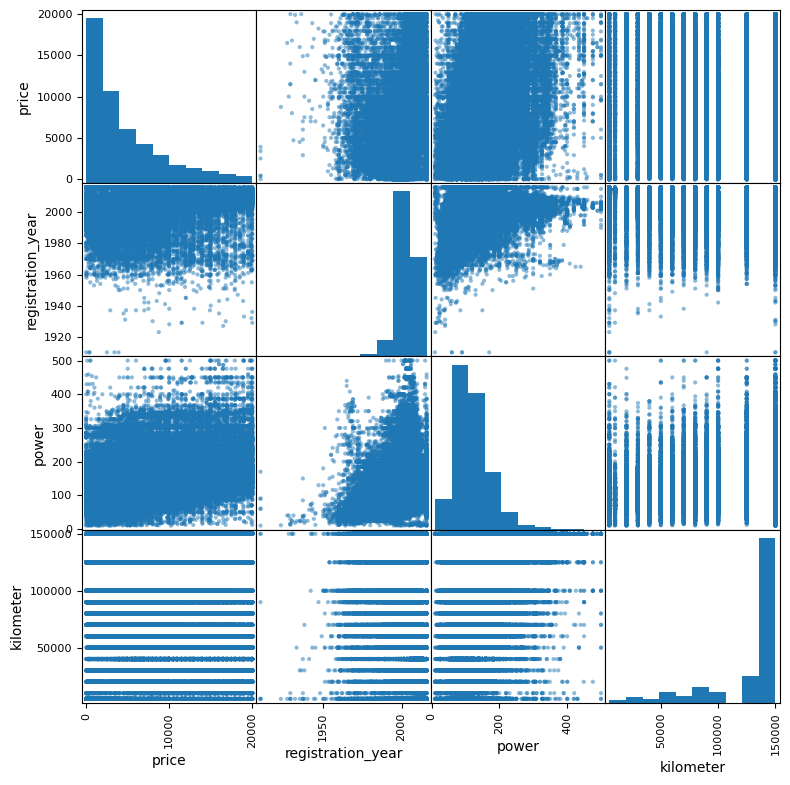

In [31]:
pd.plotting.scatter_matrix(auto_data, figsize=(9, 9))
plt.show()

Актуальность машины необязательно кореллирует с высокой стоимостью, но определённо полезна. Есть ещё несколько выбросов в районе раритетных машин, зарегистрированных ранее 1950-х. У таких машин, понятно, будет высокая стоимость. Чем мощнее машина, тем она будет вероятнее всего дороже. Все раритетные машины маломощные. Километраж не особенно влияет на цену.

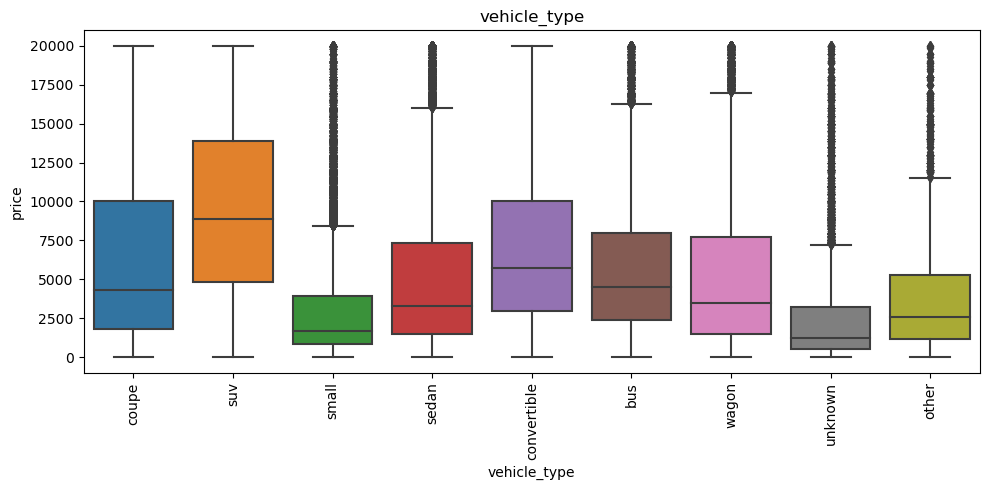

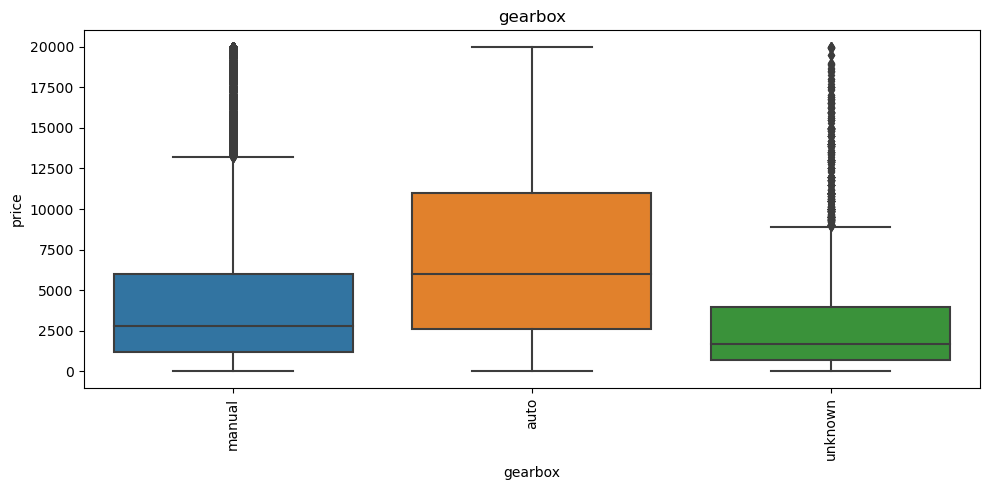

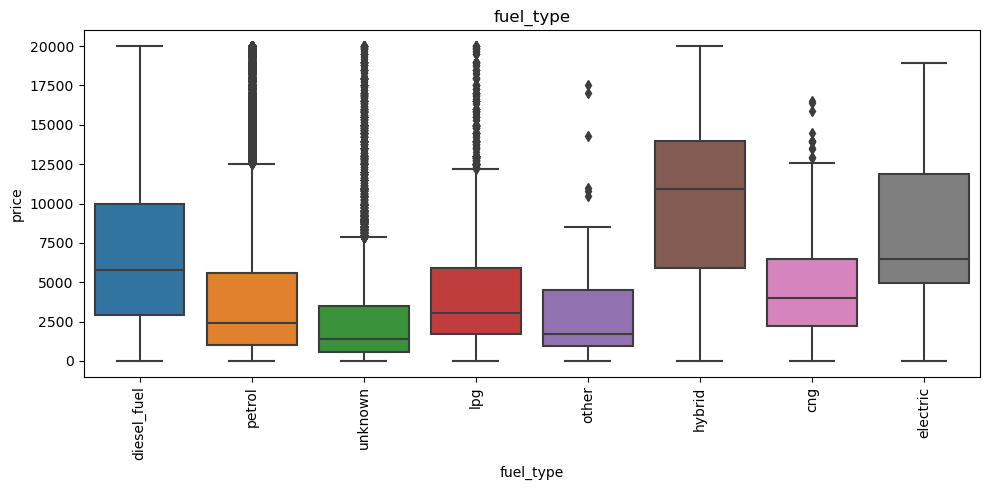

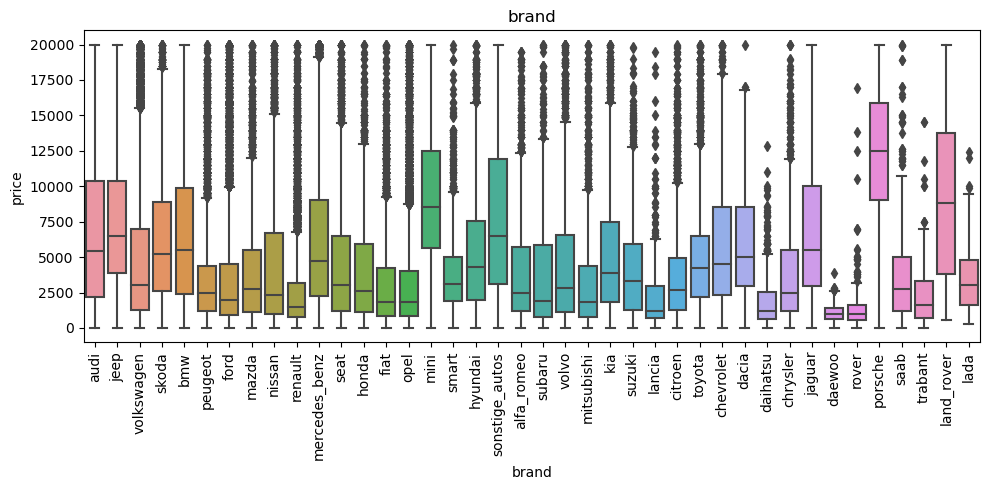

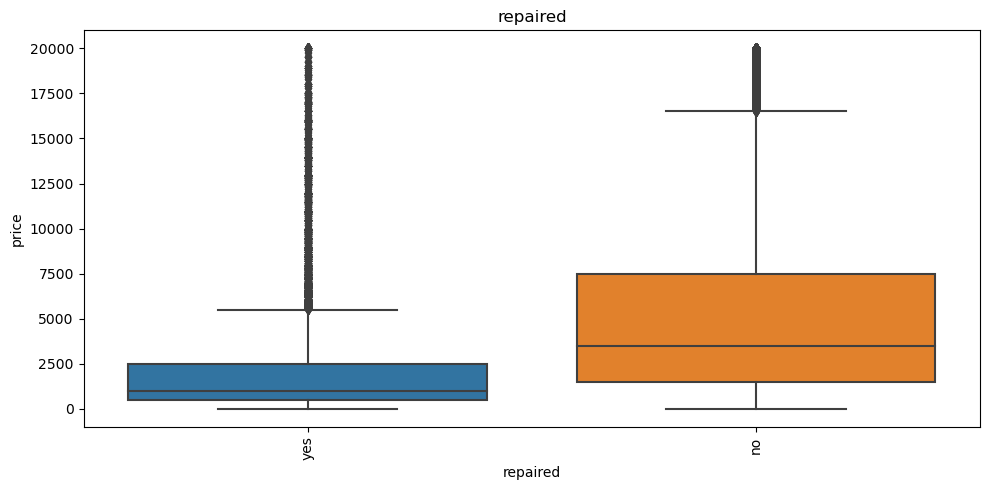

In [32]:
auto_data_cat = auto_data[['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']]

# создаю subplots
for i, cat in enumerate(auto_data_cat):
    fig, axs = plt.subplots(1, figsize=(10, 5))
    plot_data(auto_data_cat[cat], auto_data['price'], auto_data, cat, axs)
    plt.xticks(rotation=90)
    fig.tight_layout()
    plt.show()

Цены на suv стабильные и высокие, convertible и coupe тоже показывают хорошие результаты. По всем остальным типам цены меньше, но при этом есть много выбросов. Автоматическая коробка повышает цену авто, но иногда и машины на механике продаются хорошо. Дизельные машины держат стабильную и высокую цену, тогда как бензиновые дешевле. Гибридные и электрические машины дорогие в целом. Самые дорогие машины от марки Porsche, а самые дешёвые - от Daewoo. Наличие ремонта сильно снижает цену машины в целом.
Не выводила график по моделям, потому что там слишком много значений.

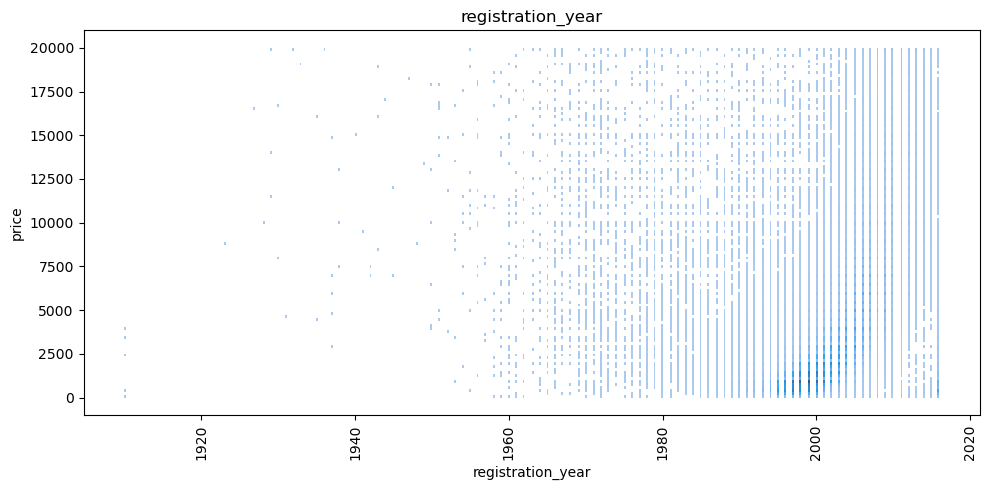

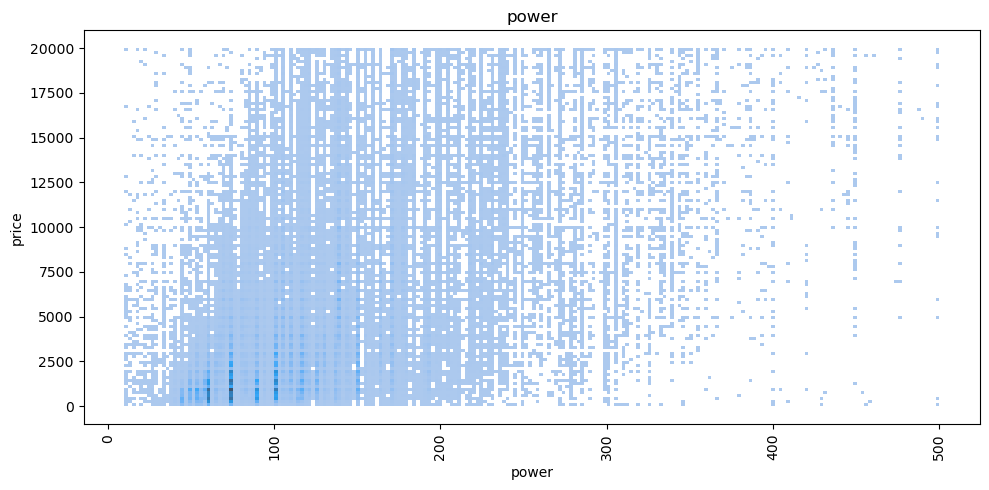

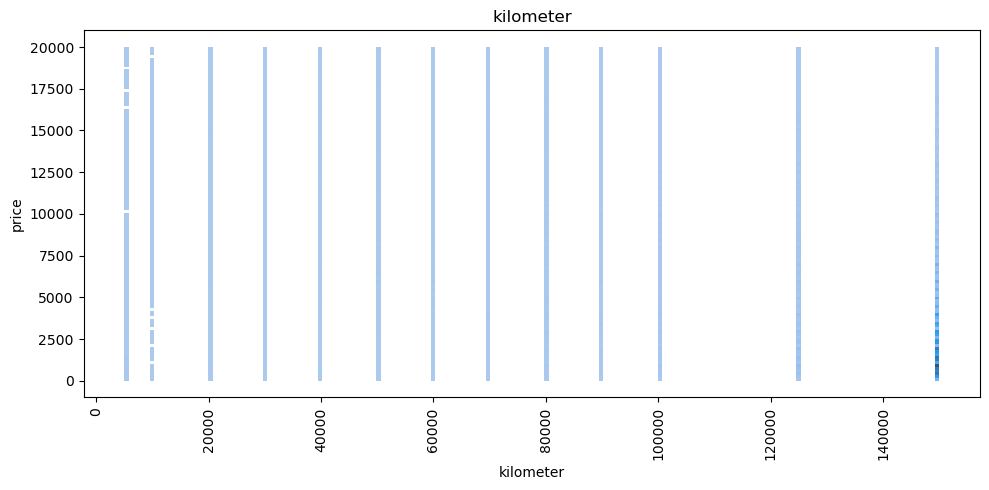

In [33]:
auto_data_num = auto_data[['price', 'registration_year', 'power', 'kilometer']]

# создаю subplots
for i, num in enumerate(auto_data_num):
    if num != 'price':
        fig, axs = plt.subplots(1, figsize=(10, 5))
        scatterplot_data(auto_data_num[num], auto_data['price'], auto_data, num, axs)
        plt.xticks(rotation=90)
        fig.tight_layout()
        plt.show()

Больше всего машин, зарегистрированных в 1990-х — 2010-х. Основная масса машин — мощностью в районе 100 л.с. Машин с пробегом больше 150 000 км чуть больше, чем остальных.

## Корреляционный анализ

In [34]:
phik_matrix = auto_data.phik_matrix(interval_cols = ['price', 'power'])

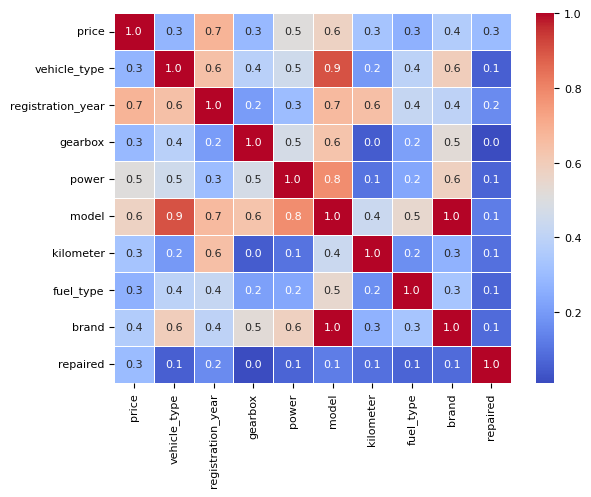

In [35]:
plt.rcParams['font.size'] = '8'
sns.heatmap(phik_matrix, annot=True, linewidth=.5, fmt=".1f", cmap='coolwarm')
plt.show()

По графику корреляций видна сильная корреляция модели с брендом, типом авто и мощностью. Удалю столбец с моделями, чтобы убрать корреляцию.

In [36]:
auto_data_for_lr = auto_data.drop('model', axis=1)
auto_data_for_lr.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
1,18300.0,coupe,2011,manual,190.0,125000,diesel_fuel,audi,yes
2,9800.0,suv,2004,auto,163.0,125000,diesel_fuel,jeep,no
3,1500.0,small,2001,manual,75.0,150000,petrol,volkswagen,no
4,3600.0,small,2008,manual,69.0,90000,diesel_fuel,skoda,no
5,650.0,sedan,1995,manual,102.0,150000,petrol,bmw,yes


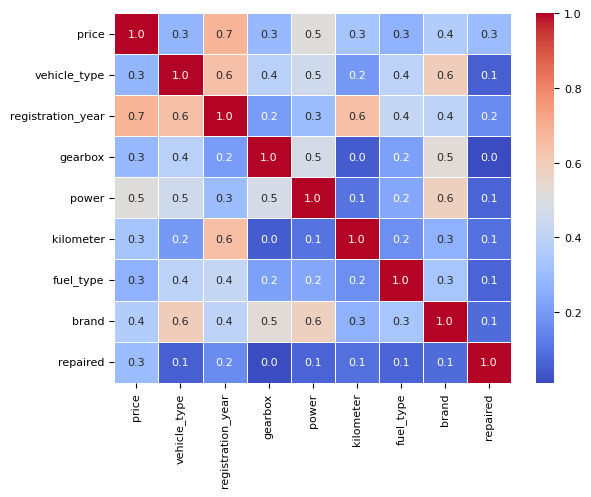

In [37]:
phik_matrix = auto_data_for_lr.phik_matrix(interval_cols = ['price', 'power'])
plt.rcParams['font.size'] = '8'
sns.heatmap(phik_matrix, annot=True, linewidth=.5, fmt=".1f", cmap='coolwarm')
plt.show()

## Пайплайн обработки данных и обучения моделей

In [38]:
auto_data.duplicated().sum()

45180

In [39]:
# в датасете появились дубликаты, удалю их
auto_data = auto_data.drop_duplicates()
auto_data.duplicated().sum()

0

In [40]:
auto_data_for_lr.duplicated().sum()

51501

In [41]:
auto_data_for_lr = auto_data_for_lr.drop_duplicates()
auto_data_for_lr.duplicated().sum()

0

Потребуются следующие преобразования значений перед обучением:

Кодировка 'vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired' с помощью OneHotEncoder. Кодировка 'power', 'kilometer', 'registration_year' с помощью StandardScaler. Для проверки качества модели - метрика RMSE. Метрика должна быть меньше 2500.

In [42]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [43]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = auto_data_for_lr.drop(['price'], axis=1)
y = auto_data_for_lr['price']

ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year','power', 'kilometer']

ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

In [44]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 20),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(1, 100),
        'models__max_depth': range(1, 20),
        'models__min_child_samples': range(1, 20),
        'models__num_leaves': range(1, 50),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X, y)

best_model = randomized_search.best_estimator_

best_model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 195834, number of used features: 60
[LightGBM] [Info] Start training from score 5042.265766


/Users/ira-bobrineva/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 195835, number of used features: 60
[LightGBM] [Info] Start training from score 5008.272096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 195835, number of used features: 60
[LightGBM] [Info] Start training from score 5009.700248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num', 'passthrough',
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('models',
                 LGBMRegressor(max_depth=15, min_child_samples=18,
                               n_estimators=99, num_leaves=20,
                               random_state=42))])

In [45]:
result = pd.DataFrame(randomized_search.cv_results_)
result = result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')
result['mean_test_score'] = result['mean_test_score'] * (-1)
print(result)
pd.set_option('display.max_colwidth', 10000)

   rank_test_score                    param_models  mean_test_score  \
1                1  LGBMRegressor(random_state=42)      1799.812160   
3                2  LGBMRegressor(random_state=42)      1800.636372   
8                3  LGBMRegressor(random_state=42)      1811.274441   
4                4  LGBMRegressor(random_state=42)      1838.729977   
9                5  LGBMRegressor(random_state=42)      1840.798016   
0                6  LGBMRegressor(random_state=42)      1952.386493   
2                7  LGBMRegressor(random_state=42)      2119.539708   
5                8  LGBMRegressor(random_state=42)      2566.693542   
7                9  LGBMRegressor(random_state=42)      2621.886934   
6               10  LGBMRegressor(random_state=42)      4283.528492   

                                              params  
1  {'preprocessor__num': 'passthrough', 'models__...  
3  {'preprocessor__num': StandardScaler(), 'model...  
8  {'preprocessor__num': StandardScaler(), 'model... 

Лучшая модель - градиентный бустинг для регрессии с гиперпараметрами num_leaves=20, n_estimators=99, min_child_samples=18, max_depth=15. На тренировочных данных метрика равна 1799.

## Эксперименты с моделями

### DecisionTreeRegressor

In [46]:
auto_data_tg = auto_data.copy()

drop_col = ['price']

X_train_tg, X_test_tg, y_train_tg, y_test_tg = data_for_model(auto_data_tg, drop_col, num_columns, ohe_columns, random_state=42)

params_for_tree = {'max_depth': range(1, 20), 'min_samples_leaf': range(1, 20),'min_samples_split': range(2, 20)}

rmse_tg_cv, model_tg = model_fit_predict(DecisionTreeRegressor(random_state=RANDOM_STATE), params_for_tree, X_train_tg, y_train_tg)

print(-rmse_tg_cv)
print(model_tg)


1864.4275280389552
DecisionTreeRegressor(max_depth=19, min_samples_leaf=7, min_samples_split=3,
                      random_state=42)


In [47]:
start_tg_train = time()

model_tg.fit(X_train_tg, y_train_tg)

end_tg_train = time()

model_time_tg_train = (end_tg_train-start_tg_train)/60

model_time_tg_train

0.010223050912221273

In [48]:
start_tg_predictions = time()

predictions_tg = model_tg.predict(X_train_tg)

end_tg_predictions = time()

model_time_tg_predictions = (end_tg_predictions-start_tg_predictions)/60

model_time_tg_predictions

0.00048456589380900067

### LinearRegression

In [49]:
auto_data_lr = auto_data_for_lr.copy()

X_train_lr, X_test_lr, y_train_lr, y_test_lr = data_for_model(auto_data_lr, drop_col, num_columns, ohe_columns, random_state=42)

params_for_lr = {}

rmse_lr_cv, model_lr = model_fit_predict(LinearRegression(), params_for_lr, X_train_lr, y_train_lr)

print(-rmse_lr_cv)

/Users/ira-bobrineva/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


2856.734193205697


In [50]:
start_lr_train = time()

model_lr.fit(X_train_lr, y_train_lr)

end_lr_train = time()

model_time_lr_train = (end_lr_train-start_lr_train)/60

model_time_lr_train

0.004120234648386637

In [51]:
start_lr_predictions = time()
predictions_lr = model_lr.predict(X_test_lr)

end_lr_predictions = time()

model_time_lr_predictions = (end_lr_predictions-start_lr_predictions)/60

rmse_lr = sqrt(mean_squared_error(y_test_lr, predictions_lr))
print(model_time_lr_predictions)
print(rmse_lr)

0.0002528707186381022
2857.465383411236


### LGBMRegressor

In [52]:
auto_data_lgbm = auto_data.copy()

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = data_for_model(auto_data_lgbm, drop_col, num_columns, ohe_columns, random_state=42)

params_for_lgbm = {'num_leaves': range(1, 50), 'n_estimators': range(1, 100),'min_child_samples': range(1, 20), 'max_depth': range(1, 20)}

rmse_lgbm_cv, model_lgbm = model_fit_predict(LGBMRegressor(random_state=RANDOM_STATE), params_for_lgbm, X_train_lgbm, y_train_lgbm)

print(-rmse_lgbm_cv)
print(model_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 188335, number of used features: 60
[LightGBM] [Info] Start training from score 4979.218170
1746.3798918784469
LGBMRegressor(max_depth=19, min_child_samples=7, n_estimators=94, num_leaves=39,
              random_state=42)


In [53]:
start_lgbm_train = time()

model_lgbm.fit(X_train_lgbm, y_train_lgbm)

end_lgbm_train = time()

model_time_lgbm_train = (end_lgbm_train-start_lgbm_train)/60

model_time_lgbm_train

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 188335, number of used features: 60
[LightGBM] [Info] Start training from score 4979.218170


0.012942934036254882

In [54]:
start_lgbm_predictions = time()

predictions_lgbm = model_lgbm.predict(X_train_lgbm)

end_lgbm_predictions = time()

model_time_lgbm_predictions = (end_lgbm_predictions-start_lgbm_predictions)/60

model_time_lgbm_predictions

0.00504986842473348

Из трёх моделей градиентный бустинг предсказывает лучше всех: rmse равно 1746. У дерева 1864, а у линейной регрессии вообще 2857. С другой стороны, дерево работает быстрее: обучение лучшей модели заняло 0,0104, а расчёт предсказаний - 0,0009. Градиентный бустинг обучался 0,0127, а предсказывал 0,005. Линейная регрессия долго обучалась - 0,004, зато предсказала за 0,0003.

## Проверка лучшей модели на тестовых данных

In [55]:
predictions_tg_test = model_tg.predict(X_test_tg)
rmse_tg_test = sqrt(mean_squared_error(y_test_tg, predictions_tg_test))
rmse_tg_test

1823.0828591502154

Дерево сохраняет качество предсказаний на тестовой выборке.

## Вывод

Я бы рекомендовала использовать регрессионное дерево для бизнес-целей. В нём сочетается и экономия мощностей, и качество предсказаний. У градиентного бустинга предсказания точнее, но обучение и расчёт предсказаний дольше. 